<a href="https://colab.research.google.com/github/rayhanozzy/Mastering-AI/blob/main/Image%20Classification%20using%20CNN/cnn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN - Project

## Project Description

In this CNN Project, you will create your own custom Image Classification. You can collect a dataset of images you are interested in and train a CNN model to differentiate between them. For example, a model could be trained to distinguish between different types of birds, cars, plants, or any other topic of interest.

In [ ]:
#Write any package/module installation that you need here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import os

## Task-1 Load the dataset

In this task, you will prepare and load your dataset. **You can choose any dataset you want**, make sure the data is diverse and large enough to prevent overfitting and improve the model's ability to generalize.

If you are using images from the internet, **please respect copyright and privacy laws**. Creative Commons licenses or public domain images are a safe bet, and many APIs (like the Unsplash API) provide access to a large number of such images.

### 1.1 Optional Custom Dataset
Provided below is a custom dataset template that you may want to use for your code. It's completely optional.

Alternatively, you can review the material on Data Augmentation or read the Pytorch tutorial https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [ ]:
#an example of creating our own custom dataset, you can use this if you want/need. Completely optional.
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### 1.2 Write your code in the block below

In the code block below, prepare and load your dataset. Please include data preprocessing steps such as dividing the dataset into training, validation, and test sets, or data augmentation techniques that you used if any in this section. Do not put the code to build your model here.

Some techniques you may use:
- Find and load existing dataset from Huggingface or Kaggle. (Easy)
- Create your own custom dataset from the images you have in your possesion or internet search and load the dataset. (Hard)
- Etc.

Hint:
- Usually the dataset are loaded into train_dataset and test_dataset

In [ ]:
# Write your data preprocessing code here
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 data using torchvision.datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Use Data Loader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 30292177.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Task-2 Build your model

In this task, you will now build and save your model. You can either create your own CNN model or choose any pretrained model that you feel is most appropriate for your dataset.

### 2.1 Write your code in the block below

In the code block below, write the code to **create your model, either from scratch or fine tuning a pretrained model**. You will need to write the code for your model definition, such as the layers used, loss function and optimizer. Please include also the training and validation loops.

Make sure you **save your model to a file** and **measure the accuracy of your model**, as this will be submitted for this task.

Some techniques you may use:
- Use pretrained model. (Easy)
- Create a CNN model from scratch. (Hard)
- Etc.

Hint:
- Use GPU in Google Colab, it significantly improves the time taken for training, compared to CPU.
- **Google Colab GPU usage for free-tier have a limit**, which is unknown, so I suggest you try out in CPU mode that your code works without error, then use GPU for traininig.
- If you are going to upload to Huggingface by using the Transformer Trainer during training, make sure you use the Huggingface method. Refer to Transfer Learning section or read the documentation here: https://huggingface.co/docs/transformers/model_sharing

In [ ]:
#Write your code to build your model here
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()  # Add parentheses to super()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model and set hyperparameters
model = CNNModel(num_classes=10)  # CIFAR-10 has 10 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Validation loop
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the model
torch.save(model.state_dict(), "cifar10_cnn_model.pth")

Epoch 1, Loss: 1.493749065876007
Epoch 2, Loss: 1.0760661284923554
Epoch 3, Loss: 0.8873490419387817
Epoch 4, Loss: 0.7633965603113174
Epoch 5, Loss: 0.678139275252819
Epoch 6, Loss: 0.6003034115433693
Epoch 7, Loss: 0.5341852638721466
Epoch 8, Loss: 0.47509050795435903
Epoch 9, Loss: 0.4216607447564602
Epoch 10, Loss: 0.38042396780848503
Epoch 11, Loss: 0.3357211081981659
Epoch 12, Loss: 0.304189172655344
Epoch 13, Loss: 0.2763716998696327
Epoch 14, Loss: 0.2512572718858719
Epoch 15, Loss: 0.2253542990088463
Epoch 16, Loss: 0.20472171010077
Epoch 17, Loss: 0.19390727688372136
Epoch 18, Loss: 0.18862871715426446
Epoch 19, Loss: 0.1721483232676983
Epoch 20, Loss: 0.1602536598071456
Epoch 21, Loss: 0.15414341182261707
Epoch 22, Loss: 0.14538057327270507
Epoch 23, Loss: 0.14360643276572227
Epoch 24, Loss: 0.13911765625700354
Epoch 25, Loss: 0.13086320772767068
Epoch 26, Loss: 0.12944770084694027
Epoch 27, Loss: 0.1256429310925305
Epoch 28, Loss: 0.11906204950809479
Epoch 29, Loss: 0.11849

## Task-3 Model Inference

In this task, you will be exercising the application of your model, or as it's commonly referred to in AI terminology, you will be performing inference using your model.

Simply load your saved model from Task-2 and create an inference for the model. Where you'll feed an image as input and the model will output the label as well as the percentage of confidence for the label.

### 3.1 Write your code in the block below

In the code block below write the code to use the model you created in Task-2. Load the model and input image, afterwards, show the result of the label/class together with confidence level in percentage as well as the input image.

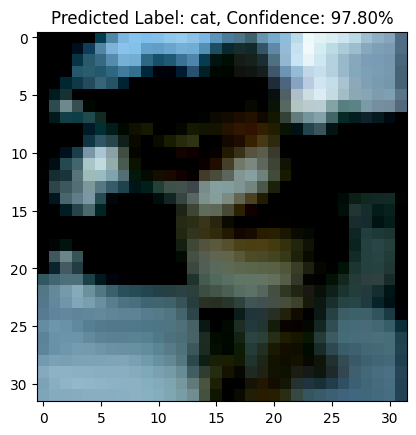

In [ ]:
#Write your code for inference here
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your trained model
model = CNNModel(num_classes=10)  # Replace with the actual model you trained
model.load_state_dict(torch.load("/content/cifar10_cnn_model.pth"))  # Load the saved model file

# Define data transformations for the input image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Load and preprocess the input image
input_image = Image.open("/content/cat3.jpg")  # Replace with the path to your input image
input_image = transform(input_image)  # Apply transformations

# Perform inference
model.eval()
with torch.no_grad():
    output = model(input_image.unsqueeze(0))  # Add batch dimension

# Get the predicted label and confidence
_, predicted = torch.max(output, 1)
confidence = torch.nn.functional.softmax(output, dim=1)[0] * 100  # Convert to percentage

# Define class labels (replace with your own class labels)
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Display the result
plt.imshow(input_image.permute(1, 2, 0))  # Show the input image
predicted_label = class_labels[predicted.item()]  # Convert tensor to Python scalar
confidence_value = confidence[predicted].item()  # Convert tensor to Python scalar
plt.title(f'Predicted Label: {predicted_label}, Confidence: {confidence_value:.2f}%')
plt.show()

## Task-4 Model Publishing

In this task, you will push your model to Huggingface. Once you've pushed your model to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

### 4.1 Write your code in the block below

In the code block below, write the code to push your model to Huggingface. There are several methods to do this, please refer to the documentation: https://huggingface.co/docs/transformers/model_sharing

Some techniques you may use:
- If you use the Transformer Trainer during the training loop when you create your model above, then you can simply put your `trainer.push_to_hub()` here.
- You can also use the web interface on Huggingface.

Hint:
- Remember to login first to your Huggingface account.
- If you are pushing programmaticaly, then use the huggingface-cli to login.

In [ ]:
#Write your code for publishing here
